### Setup

In [1]:
# magic reload
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from analysis.plot_utils import *
from datasets import load_dataset
from collections import Counter

In [2]:
all_df = prepare_df()

### 2 vs 4 choice

In [3]:
verdict_ids_2_choice_gpqa =  ['o6nh196', 'se5tc1t', 'okcg9s1', 'px68tl7', 'gt5hbbc', 'omurjjz', '2ayhhpd', '7ir6j2d', 'mr8lipz', 'kn8lecm', 'k26y5y6', 'uopuf76', 'hmsolpd', 'wvubqq5', '0q341gz', 'm6zo8vx', 'jgrph0e']
verdict_ids_4_choice_gpqa =  ['2bmbqk1', 'po3v9oq', 'qx50tbo', 'jm9kod3', '4rg7b4b', 'faqmo5o', 'dph0qre', '9jiz6cv', 'p8zeu0p', 'ouuwuug', 'yt32eoi', 'vwmy4y3', 'qiqr2wo', '2pvnm1z', 'ujzubt9', '4ukh5h7', '3oxc0v3']

df_2_choice_gpqa = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa)]
df_4_choice_gpqa = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids_4_choice_gpqa)]

acc_2_choice_gpqa = aggregate_by_fields(df_2_choice_gpqa, ['config_judge_model_verdicts'])
acc_4_choice_gpqa = aggregate_by_fields(df_4_choice_gpqa, ['config_judge_model_verdicts'])

In [4]:
df_4_choice_gpqa[['config_judge_model_verdicts', 'verdict_run_id_verdicts']].value_counts()

config_judge_model_verdicts         verdict_run_id_verdicts
meta-llama/llama-3.1-70b-instruct   4rg7b4b                    188
google/gemma-3-27b-it               po3v9oq                    188
meta-llama/llama-3-8b-instruct      qx50tbo                    187
meta-llama/llama-3.1-8b-instruct    faqmo5o                    187
meta-llama/llama-3.3-70b-instruct   dph0qre                    187
qwen/qwen-2.5-7b-instruct           qiqr2wo                    187
openai/gpt-4o-mini                  yt32eoi                    187
meta-llama/llama-3.1-405b-instruct  jm9kod3                    186
google/gemma-3-12b-it               2bmbqk1                    185
openai/gpt-3.5-turbo                ouuwuug                    185
qwen/qwen-2.5-72b-instruct          vwmy4y3                    184
meta-llama/llama-4-scout            p8zeu0p                    182
meta-llama/llama-4-maverick         9jiz6cv                    151
qwen/qwen3-14b                      2pvnm1z                    144
qw

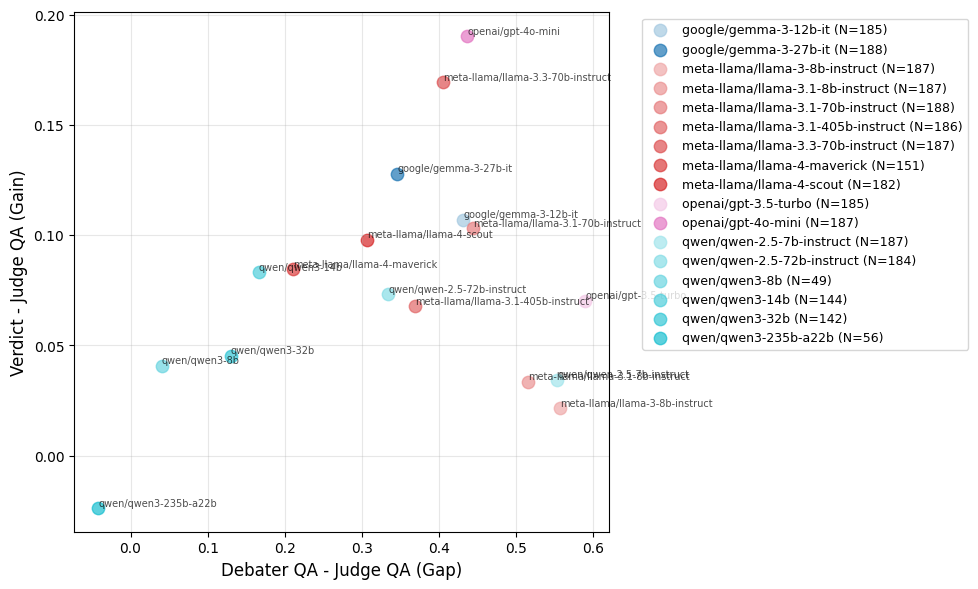

In [5]:
results_df = acc_4_choice_gpqa
# results_df = results_df[results_df['n_total'] > 45]
plot_gain_scatter(results_df, n_choices=4, over='gap') # or over=judge_qa

(<module 'matplotlib.pyplot' from '/Users/joshlevy/.pyenv/versions/3.11.13/envs/llm_judge_debate_NEW_env/lib/python3.11/site-packages/matplotlib/pyplot.py'>,
 <Axes: xlabel='Judge Model', ylabel='Gain'>,
 <Axes: xlabel='Judge Model', ylabel='Gap'>)

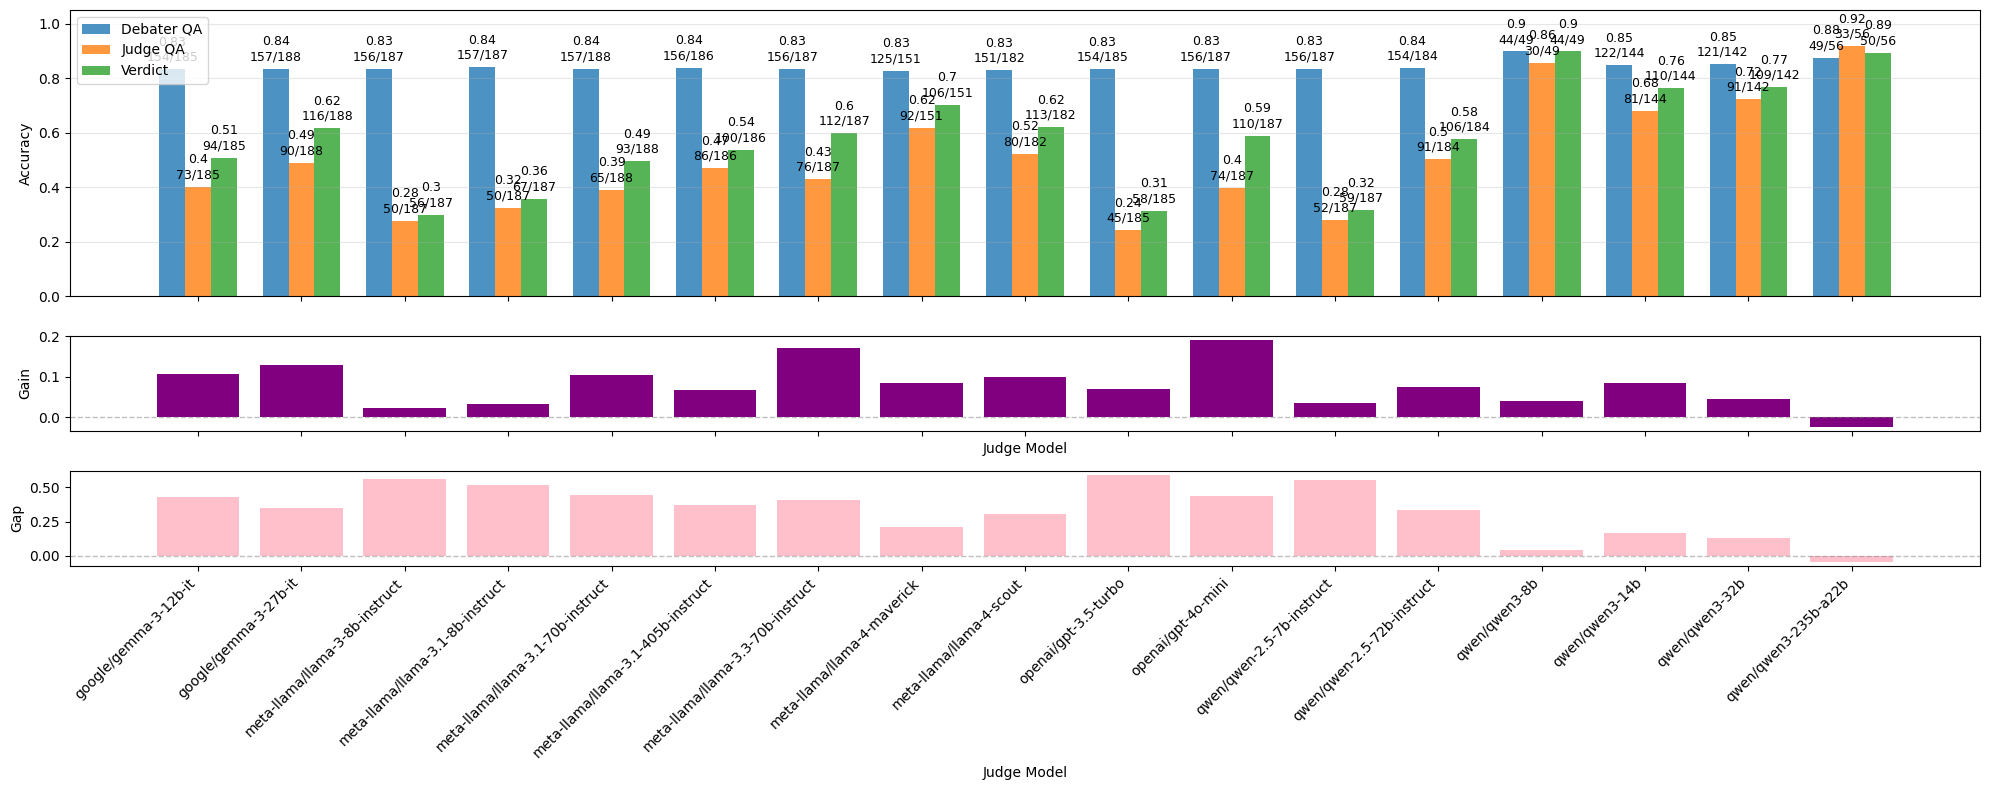

In [6]:
plot_results_by_name(acc_4_choice_gpqa)

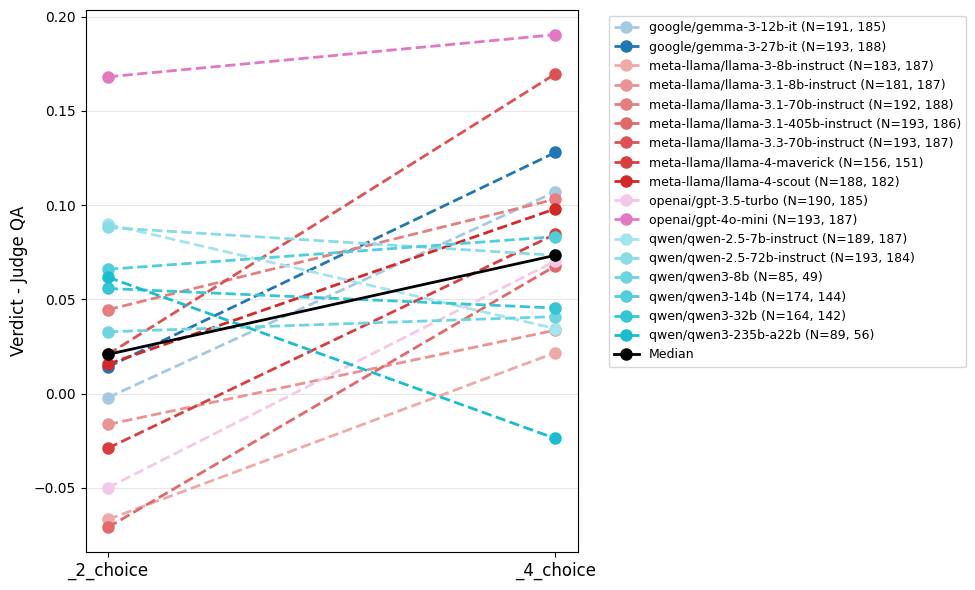

In [7]:
suffixes = ['_2_choice', '_4_choice']
merged_choice = acc_2_choice_gpqa.merge(acc_4_choice_gpqa, on='name', suffixes=suffixes)

plot_spaghetti(merged_choice, suffixes)

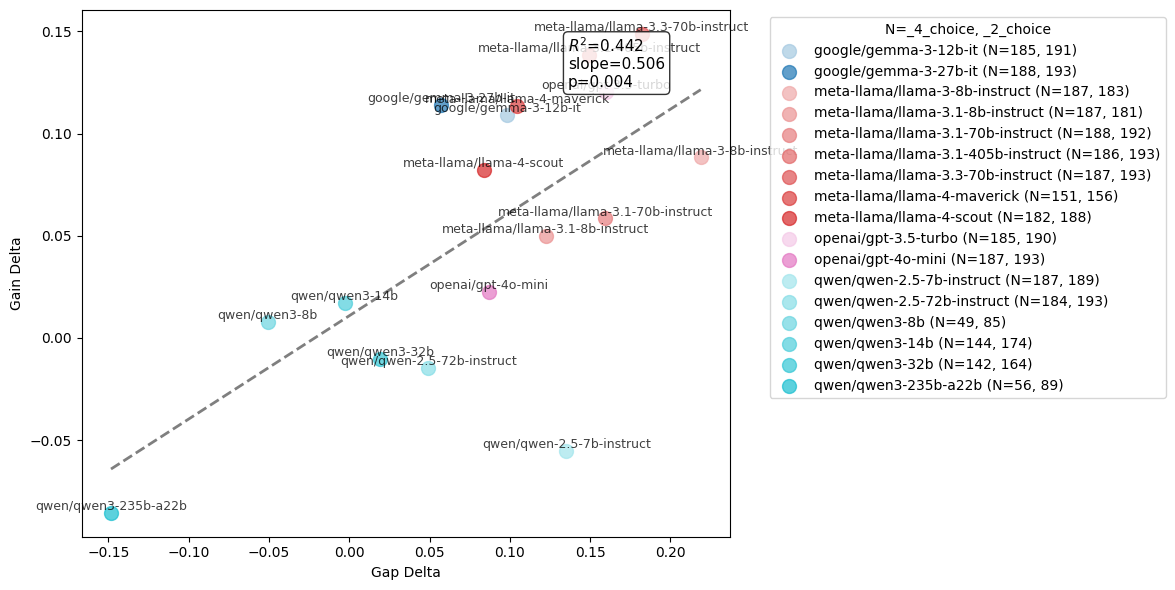

In [8]:
suffixes = ['_4_choice', '_2_choice']

temp = merged_choice[(merged_choice[f'n_total{suffixes[0]}'] > 45) & (merged_choice[f'n_total{suffixes[1]}'] > 45)]
plot_delta_over_delta(temp, suffixes, xfield='gap_delta', yfield='gain_delta', n_min=20)

### Breakdown by category

In [9]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)

In [10]:
# temp_df = all_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
temp_df = df_4_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
# temp_df = df_2_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))


chemistry_df = temp_df[temp_df['high_level_domain'] == 'Chemistry']
physics_df = temp_df[temp_df['high_level_domain'] == 'Physics']

chemistry_gpqa_acc = aggregate_by_fields(chemistry_df, ['config_judge_model_verdicts'])
physics_gpqa_acc = aggregate_by_fields(physics_df, ['config_judge_model_verdicts'])

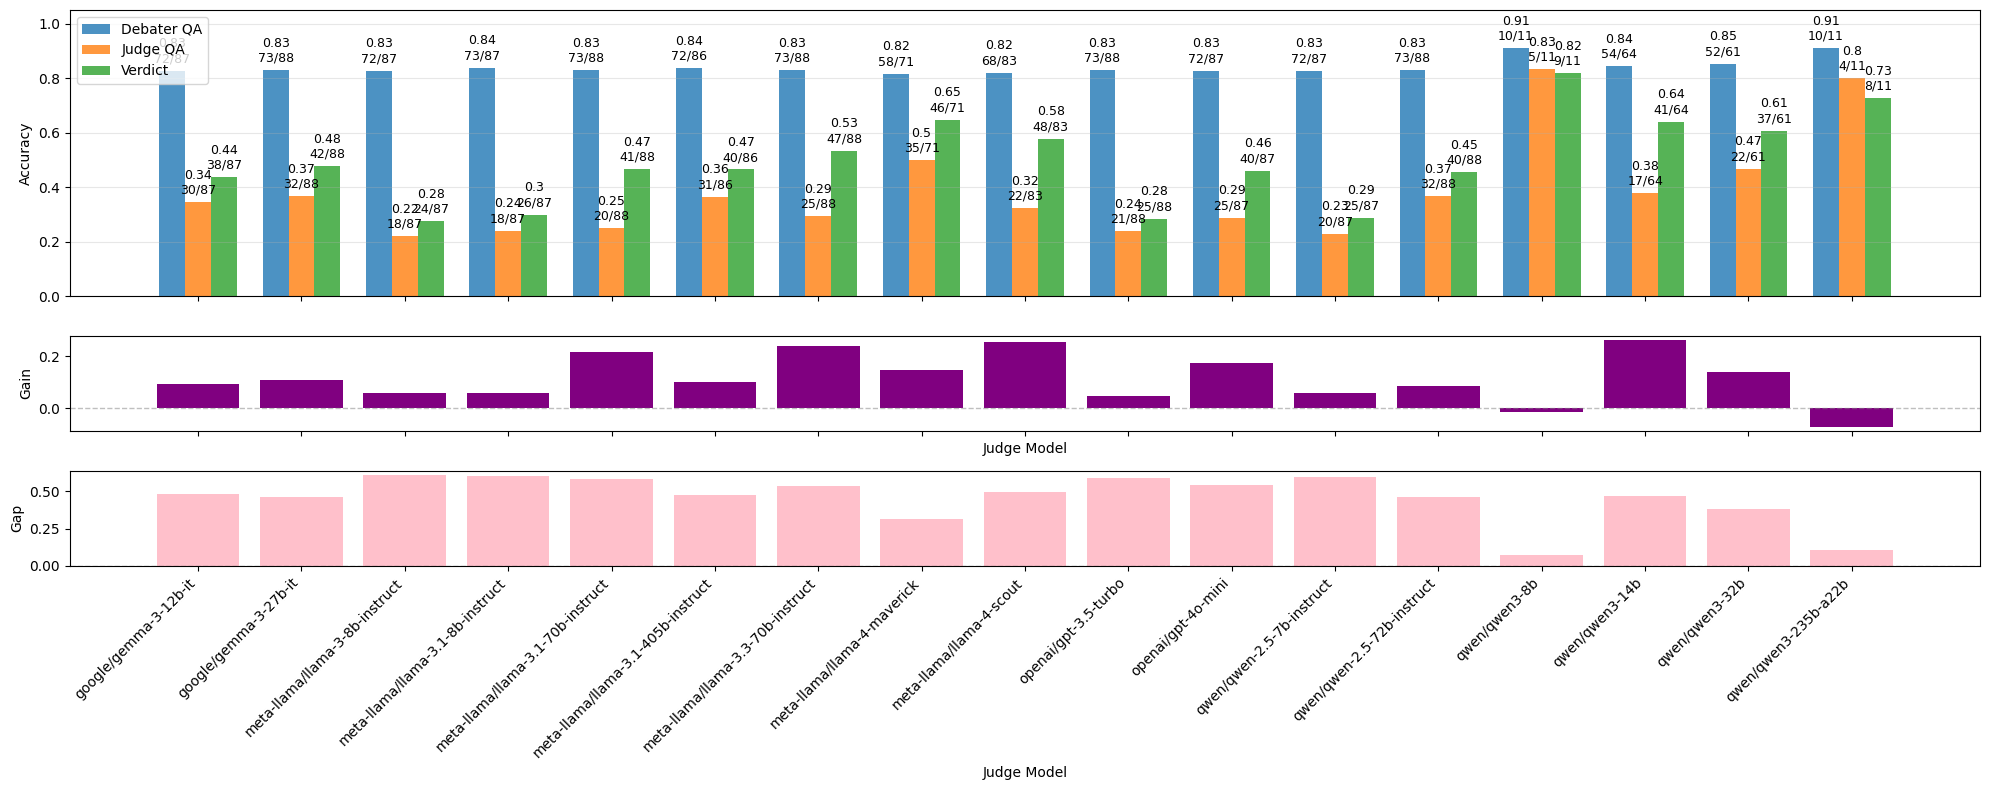

In [13]:
plot_results_by_name(chemistry_gpqa_acc)
plt.show()

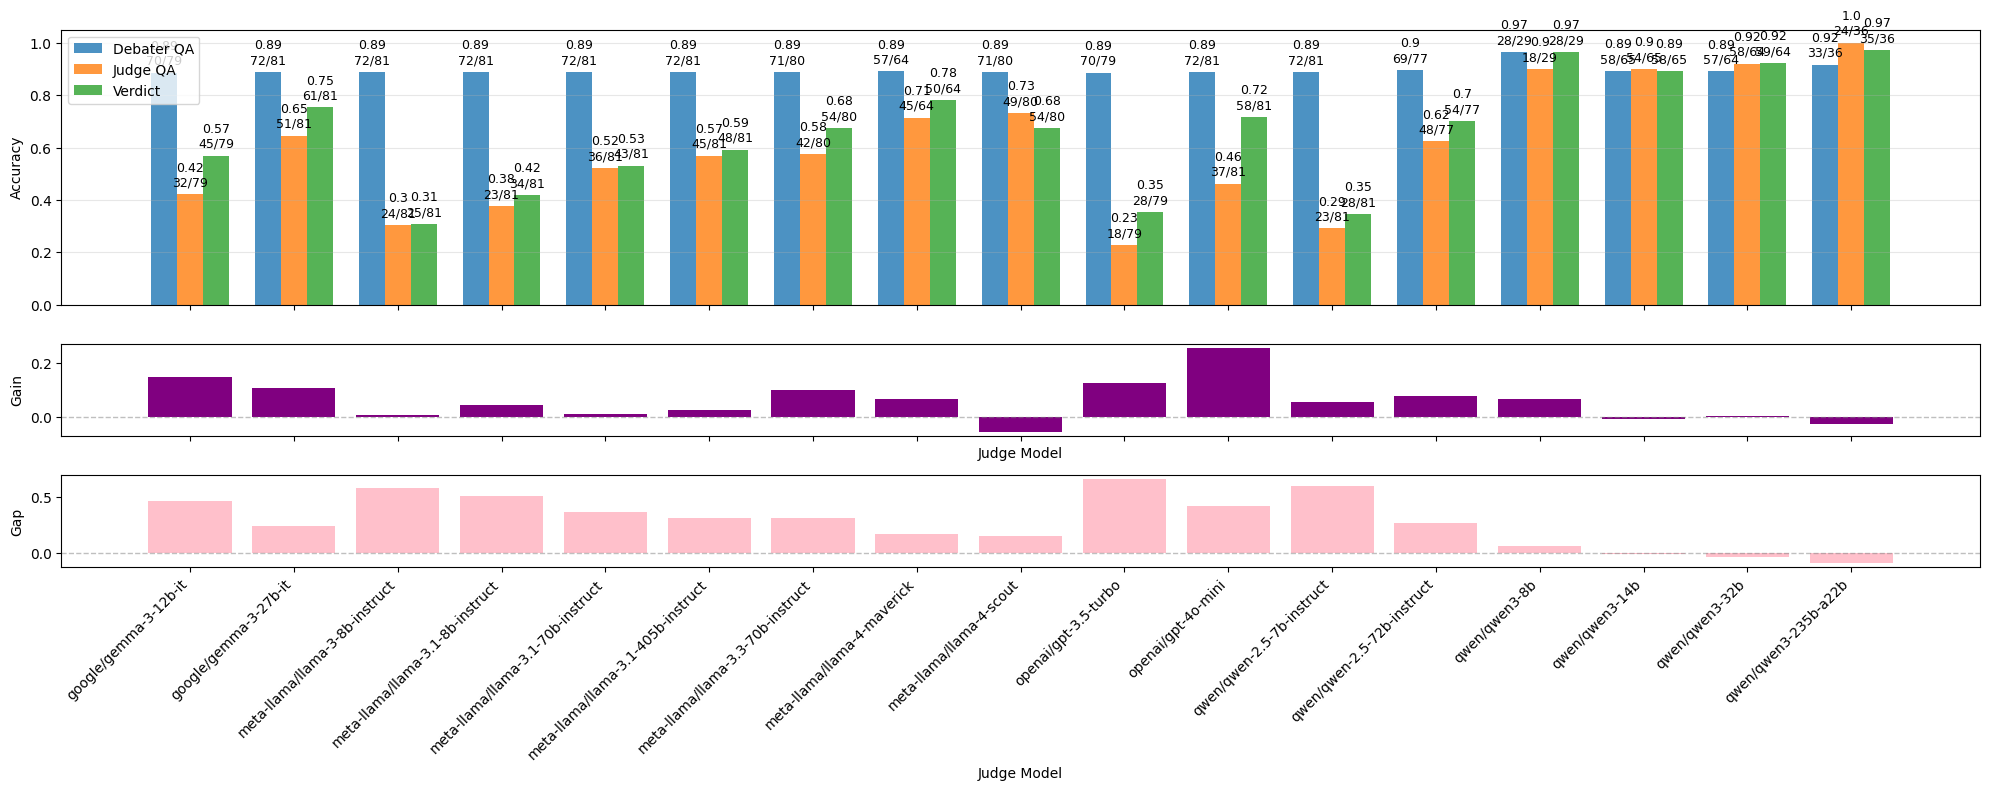

In [14]:
plot_results_by_name(physics_gpqa_acc)
plt.show()

skipping qwen/qwen3-8b because too few samples: n_0 = 11 and n_1 = 29
skipping qwen/qwen3-235b-a22b because too few samples: n_0 = 11 and n_1 = 36


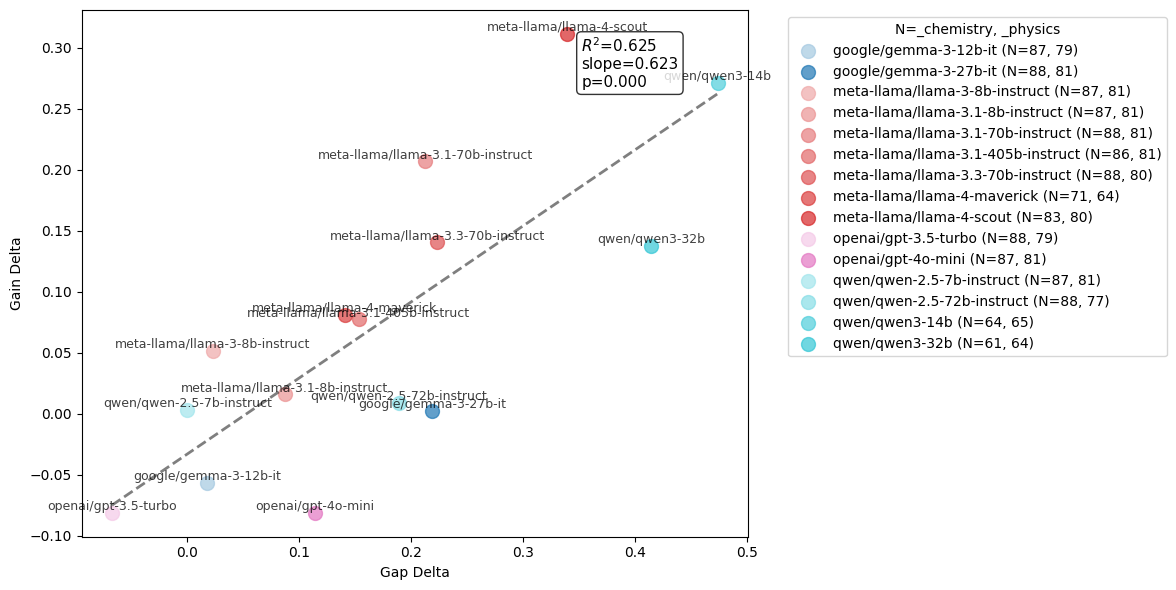

In [15]:
suffixes = ['_chemistry', '_physics']
merged_domains = chemistry_gpqa_acc.merge(physics_gpqa_acc, on='name', suffixes=suffixes)

plot_delta_over_delta(merged_domains, suffixes, xfield='gap_delta', yfield='gain_delta', n_min=20)

### Which models used internal reasoning?

In [16]:
# df_4_choice_gpqa['judge_verdict_verdicts'].apply(lambda x: x.get('token_usage').get('completion_tokens_details')).value_counts()

def get_verdict_reasoning_tokens(x):
    completion_tokens_details = x['token_usage'].get('completion_tokens_details')
    if completion_tokens_details is None:
        return 0
    else:
        return completion_tokens_details.get('reasoning_tokens', 0)

df_4_choice_gpqa['judge_reasoning_tokens'] = df_4_choice_gpqa['judge_verdict_verdicts'].apply(lambda x: get_verdict_reasoning_tokens(x))
df_4_choice_gpqa.groupby('config_judge_model_verdicts')['judge_reasoning_tokens'].sum()



/var/folders/9l/xmd1jn1s1gg47vfyv_n8g3xh0000gn/T/ipykernel_77556/2717184287.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_choice_gpqa['judge_reasoning_tokens'] = df_4_choice_gpqa['judge_verdict_verdicts'].apply(lambda x: get_verdict_reasoning_tokens(x))


config_judge_model_verdicts
google/gemma-3-12b-it                     0
google/gemma-3-27b-it                     0
meta-llama/llama-3-8b-instruct            0
meta-llama/llama-3.1-405b-instruct        0
meta-llama/llama-3.1-70b-instruct         0
meta-llama/llama-3.1-8b-instruct          0
meta-llama/llama-3.3-70b-instruct         0
meta-llama/llama-4-maverick               0
meta-llama/llama-4-scout                  0
openai/gpt-3.5-turbo                      0
openai/gpt-4o-mini                        0
qwen/qwen-2.5-72b-instruct                0
qwen/qwen-2.5-7b-instruct                 0
qwen/qwen3-14b                            0
qwen/qwen3-235b-a22b                      0
qwen/qwen3-32b                        36727
qwen/qwen3-8b                             0
Name: judge_reasoning_tokens, dtype: int64

<Axes: >

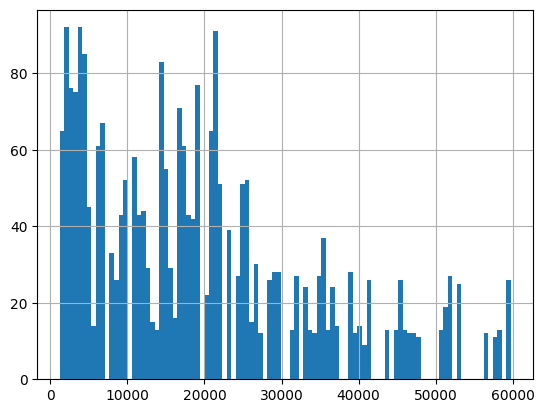

In [39]:
df_4_choice_gpqa['debate_history_debates'].apply(lambda x: sum_reasoning_tokens_over_turns(x)).hist(bins=100)

In [42]:
df_4_choice_gpqa['debate_history_debates'].apply(lambda x: x[1]['internal_model_reasoning']).value_counts()

Series([], Name: count, dtype: int64)

### Look for potential issues in debates (correct answer leaks)

In [95]:
leak_check_harcoded = []
tot_issues = 0
unique_debates_df = df_4_choice_gpqa.drop_duplicates(subset=['debate_history_debates'])
issue_types = []
tot_checks = 0
for idx, row in unique_debates_df.iterrows():
    debate_history = row['debate_history_debates']
    for turn in debate_history:
        if turn['debater_idx'] == row['correct_idx_debates']:
            continue
        public_argument = turn['parsed_response']['public_argument'].lower()
        issue_found = False
        if 'private' in public_argument:
            issue_type = 'private in argument'
            issue_found = True  
        elif 'public' in public_argument:
            issue_type = 'public in argument'
            issue_found = True
        elif 'my answer is wrong' in public_argument:
            issue_type = 'wrong in argument'
            issue_found = True
        elif 'but wait' in public_argument:
            issue_type = 'but wait in argument'
            issue_found = True
        elif 'made a mistake' in public_argument:
            issue_type = 'mistake in argument'
            issue_found = True
        elif 'actually' in public_argument:
            issue_type = 'actually in argument'
            issue_found = True
        elif 'wait' in public_argument:
            issue_type = 'wait in argument'
            issue_found = True
        if issue_found:
            # print('='*80)
            # print(f"issue_type: {issue_type}, run_id: {row['run_id_debates']}, record_id: {row['record_id_debates']}, debater_idx: {turn['debater_idx']}, turn: {turn['turn']}, success: {row['success_debates']}\noption_str: {row['options_str_debates']}\ncorrect_idx: {row['correct_idx_debates']}")
            # print('='*80)
            # print(public_argument)
            leak_check_harcoded.append({
                'run_id': row['run_id_debates'],
                'record_id': row['record_id_debates'],
                'debater_idx': turn['debater_idx'],
                'turn_idx': turn['turn'],
                'issue_type': issue_type,
            })

            issue_types.append(issue_type)
            tot_issues += 1
        tot_checks += 1

print(f"\n\ntotal issues: {tot_issues}")
print(f"total checks: {tot_checks}")
print(Counter(issue_types))



total issues: 22
total checks: 564
Counter({'wait in argument': 12, 'actually in argument': 6, 'but wait in argument': 3, 'public in argument': 1})


In [96]:
check_harcoded_df = pd.DataFrame(leak_check_harcoded)
check_harcoded_df.head()

,run_id,record_id,debater_idx,turn_idx,issue_type
0,q6wpwb7,gmwguws,0,0,wait in argument
1,q6wpwb7,gmwguws,1,0,actually in argument
2,q6wpwb7,e3dywmv,0,0,wait in argument
3,q6wpwb7,chnxivi,2,0,actually in argument
4,q6wpwb7,qi4aisn,0,0,actually in argument


In [99]:
debate_id = 'q6wpwb7'

file = get_project_root() / 'results' / 'debate_checks' / f'{debate_id}.jsonl'

check_llm_df = df = pd.read_json(file, lines=True).drop_duplicates(subset=['record_id', 'debater_idx', 'turn_idx'], keep='last')

In [101]:
check_llm_df.head()

,success,run_id,record_id,debater_idx,turn_idx,error,public_argument,raw_response,parsed_response,prompt,prompt_template,leak_types
1113,True,q6wpwb7,njb54u3,0,0,NaN,"The molecule benzo[1,2-c:3,4-c':5,6-c'']trifur...",<BEGIN ANALYSIS>\nThe debater's argument prese...,{'analysis': 'The debater's argument presents ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...
1114,True,q6wpwb7,h8gki61,0,0,NaN,"The observed peak at 790 nm, with a significan...",<BEGIN ANALYSIS>\nThe debater's argument confi...,{'analysis': 'The debater's argument confident...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...
1115,True,q6wpwb7,v4sxc3c,2,0,NaN,The experiment involves oral delivery of GFP-t...,<BEGIN ANALYSIS>\nThe debater's argument confi...,{'analysis': 'The debater's argument confident...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...
1116,True,q6wpwb7,8ns9h2k,0,0,NaN,The experimental setup involves a bicistronic ...,<BEGIN ANALYSIS>\nThe debater's argument confi...,{'analysis': 'The debater's argument confident...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...
1117,True,q6wpwb7,qc8i62f,0,0,NaN,"In structure-based drug discovery, in silico d...",<BEGIN ANALYSIS>\nThe debater's argument stron...,{'analysis': 'The debater's argument strongly ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...


In [104]:
check_llm_df['has_leak'] = check_llm_df['parsed_response'].apply(lambda x: x.get('leaks_detected'))
check_llm_df['has_leak'].value_counts()

has_leak
False    482
True      82
Name: count, dtype: int64

In [106]:
check_llm_df[check_llm_df['has_leak'] == True].head()

,success,run_id,record_id,debater_idx,turn_idx,error,public_argument,raw_response,parsed_response,prompt,prompt_template,leak_types,has_leak
1164,True,q6wpwb7,gmwguws,3,0,NaN,"Ladies and gentlemen of the jury, the correct ...",<BEGIN ANALYSIS>\nThe debater's argument stron...,{'analysis': 'The debater's argument strongly ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True
1167,True,q6wpwb7,k01tugj,2,0,NaN,"In ChIP-seq experiments, paraformaldehyde (PFA...",<BEGIN ANALYSIS>\nThe debater's argument const...,{'analysis': 'The debater's argument construct...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True
1171,True,q6wpwb7,f307sos,2,0,NaN,The question identifies the effective particle...,<BEGIN ANALYSIS>\nThe debater's argument provi...,{'analysis': 'The debater's argument provides ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True
1189,True,q6wpwb7,d75hcg3,3,0,NaN,"Ladies and gentlemen, the question asks which ...",<BEGIN ANALYSIS>\nThe debater's argument stron...,{'analysis': 'The debater's argument strongly ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True
1192,True,q6wpwb7,h8gki61,2,0,NaN,"The observed peak at 790 nm, with a significan...",<BEGIN ANALYSIS>\nThe debater's argument ident...,{'analysis': 'The debater's argument identifie...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True


In [ ]:
merged_hardcoded_to_llm = check_harcoded_df.merge(
    check_llm_df[['run_id', 'record_id', 'debater_idx', 'turn_idx', 'has_leak']],
    on=['run_id', 'record_id', 'debater_idx', 'turn_idx'],
    how='left'
)

llm_found = merged_hardcode_to_llm['has_leak'] == True
llm_missed = merged_hardcode_to_llm['has_leak'] != True

print(f"Hardcoded found: {len(check_harcoded_df)} issues")
print(f"LLM also found: {llm_found.sum()} ({llm_found.sum() / len(check_harcoded_df) * 100:.1f}%)")
print(f"LLM missed: {llm_missed.sum()} ({llm_missed.sum() / len(check_harcoded_df) * 100:.1f}%)")

Hardcoded found: 22 issues
LLM also found: 19 (86.4%)
LLM missed: 3 (13.6%)


In [111]:
merged[llm_missed]

,run_id,record_id,debater_idx,turn_idx,issue_type,has_leak
2,q6wpwb7,e3dywmv,0,0,wait in argument,False
3,q6wpwb7,chnxivi,2,0,actually in argument,False
11,q6wpwb7,8z5d2f4,3,0,wait in argument,False


In [118]:
merged_llm_to_hardcoded = check_llm_df.merge(
    check_harcoded_df[['run_id', 'record_id', 'debater_idx', 'turn_idx', 'issue_type']],
    on=['run_id', 'record_id', 'debater_idx', 'turn_idx'],
    how='left'
)
merged_llm_to_hardcoded

merged_llm_to_hardcoded[merged_llm_to_hardcoded['has_leak'] & merged_llm_to_hardcoded['issue_type'].isna()]

,success,run_id,record_id,debater_idx,turn_idx,error,public_argument,raw_response,parsed_response,prompt,prompt_template,leak_types,has_leak,issue_type
51,True,q6wpwb7,gmwguws,3,0,NaN,"Ladies and gentlemen of the jury, the correct ...",<BEGIN ANALYSIS>\nThe debater's argument stron...,{'analysis': 'The debater's argument strongly ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
54,True,q6wpwb7,k01tugj,2,0,NaN,"In ChIP-seq experiments, paraformaldehyde (PFA...",<BEGIN ANALYSIS>\nThe debater's argument const...,{'analysis': 'The debater's argument construct...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
58,True,q6wpwb7,f307sos,2,0,NaN,The question identifies the effective particle...,<BEGIN ANALYSIS>\nThe debater's argument provi...,{'analysis': 'The debater's argument provides ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
76,True,q6wpwb7,d75hcg3,3,0,NaN,"Ladies and gentlemen, the question asks which ...",<BEGIN ANALYSIS>\nThe debater's argument stron...,{'analysis': 'The debater's argument strongly ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
79,True,q6wpwb7,h8gki61,2,0,NaN,"The observed peak at 790 nm, with a significan...",<BEGIN ANALYSIS>\nThe debater's argument ident...,{'analysis': 'The debater's argument identifie...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,True,q6wpwb7,fjjn6s8,3,0,NaN,The objective is to identify the EMS-induced m...,<BEGIN ANALYSIS>\nThe debater's argument confi...,{'analysis': 'The debater's argument confident...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
557,True,q6wpwb7,ma28ixn,2,0,NaN,The initial NN state is ^1S_0: singlet spin S=...,<BEGIN ANALYSIS>\nThe debater's argument attem...,{'analysis': 'The debater's argument attempts ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
558,True,q6wpwb7,vefg04z,0,0,NaN,Star2 and Star3 can be detected with both ESPR...,<BEGIN ANALYSIS>\nThe debater's argument suppo...,{'analysis': 'The debater's argument supports ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
560,True,q6wpwb7,pkt4ycj,1,0,NaN,The solution is a phosphate buffer dominated b...,<BEGIN ANALYSIS>\nThe debater's argument inclu...,{'analysis': 'The debater's argument includes ...,You are analyzing a debate argument to detect ...,You are analyzing a debate argument to detect ...,{'1': 'Explicitly stating or implying that the...,True,NaN
